<a href="https://colab.research.google.com/github/Disha1203/Privacy-preserving-FL/blob/main/Gradient_leakage_DP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install opacus


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 254.4/254.4 kB 5.6 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE
from opacus import PrivacyEngine
from google.colab import files

In [8]:
uploaded = files.upload()
df = pd.read_csv("no_anonymistion1.csv")
print("Shape:", df.shape)
df.head()

Shape: (12874, 39)


,education,urban,gender,engnat,screensize,uniquenetworklocation,hand,religion,orientation,race,...,TIPI2,TIPI3,TIPI4,TIPI5,TIPI6,TIPI7,TIPI8,TIPI9,TIPI10,Condition
0,University degree,Urban,Female,No,Small screen,Unique network,Right,Muslim,Heterosexual,Asian,...,6,2,7,4,6,4,7,2,7,Extremely Severe
1,High school,Suburban,Male,No,Small screen,Shared network,Right,Muslim,Heterosexual,Asian,...,4,1,7,1,7,7,7,3,7,Extremely Severe
2,High school,Suburban,Female,Yes,Small screen,Unique network,Right,Christian (Catholic),Homosexual,White,...,4,1,1,1,1,4,4,3,3,Extremely Severe
3,Less than high school,Suburban,Male,No,Small screen,Unique network,Right,Christian (Catholic),Bisexual,Asian,...,5,4,4,5,5,5,5,5,4,Normal
4,High school,Urban,Female,No,Big screen,Unique network,Right,Christian (Mormon),Heterosexual,Asian,...,6,7,7,4,7,7,5,2,2,Extremely Severe


In [9]:
from sklearn.preprocessing import LabelEncoder

df_encoded = df.copy()
label_encoders = {}
target_column = 'Condition'

# Encode all categorical columns except the target
for col in df_encoded.select_dtypes(include='object').columns:
    if col != target_column:
        le = LabelEncoder()
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))
        label_encoders[col] = le

# Encode the target as well
le_target = LabelEncoder()
df_encoded[target_column] = le_target.fit_transform(df_encoded[target_column])

# Now split from df_encoded
X = df_encoded.drop(columns=[target_column])
y = df_encoded[target_column]

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)



In [10]:
#normalise the dataset to make it ideal for attacks
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_val_scaled = scaler.transform(X_val)

# Then create tensors again with X_train_scaled


In [11]:
# Check and encode any remaining non-numeric features
for col in X_train.columns:
    if X_train[col].dtype == 'object' or X_train[col].dtype.name == 'category':
        le = LabelEncoder()
        X_train[col] = le.fit_transform(X_train[col])

# Now retry SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)


In [12]:
import torch
from torch.utils.data import TensorDataset, DataLoader

# Convert to PyTorch tensors (make sure all are numeric)
X_train_tensor = torch.tensor(X_train_sm.values, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_sm, dtype=torch.long)
X_val_tensor = torch.tensor(X_val.values, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)



In [ ]:
# !pip install diffprivlib
# !pip install imbalanced-learn

In [13]:
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[1]
num_classes = len(np.unique(y))
model = MLP(input_dim, num_classes)




In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

privacy_engine = PrivacyEngine()
model, optimizer, train_loader = privacy_engine.make_private(
    module=model,
    optimizer=optimizer,
    data_loader=train_loader,
    noise_multiplier=1.0,
    max_grad_norm=1.0,
)


/usr/local/lib/python3.12/dist-packages/opacus/privacy_engine.py:96: UserWarning: Secure RNG turned off. This is perfectly fine for experimentation as it allows for much faster training performance, but remember to turn it on and retrain one last time before production with ``secure_mode`` turned on.
  warnings.warn(


In [15]:
model.train()
epochs = 10
for epoch in range(epochs):
    total_loss = 0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}/{epochs} - Loss: {total_loss:.4f}")


/tmp/ipython-input-1331209694.py:9: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


Epoch 1/10 - Loss: 370.5511
Epoch 2/10 - Loss: 272.4149
Epoch 3/10 - Loss: 240.4534
Epoch 4/10 - Loss: 219.8807
Epoch 5/10 - Loss: 209.0636
Epoch 6/10 - Loss: 204.3795
Epoch 7/10 - Loss: 207.3173
Epoch 8/10 - Loss: 207.4969
Epoch 9/10 - Loss: 215.4240
Epoch 10/10 - Loss: 235.1006


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [17]:
# After training loop
model.disable_hooks()

# Access the raw module
raw_model = model._module.to(device)

In [18]:
X_sample, y_sample = next(iter(train_loader))
X_sample = X_sample[:1].to(device)
y_sample = y_sample[:1].to(device)

loss_fn = nn.CrossEntropyLoss()

raw_model.zero_grad()
pred = raw_model(X_sample)
loss = loss_fn(pred, y_sample)
loss.backward()

# Store these DP-trained gradients
grads = [param.grad.detach().clone() for param in raw_model.parameters() if param.grad is not None]


/tmp/ipython-input-127068039.py:10: UserWarning: Full backward hook is firing when gradients are computed with respect to module outputs since no inputs require gradients. See https://docs.pytorch.org/docs/main/generated/torch.nn.Module.html#torch.nn.Module.register_full_backward_hook for more details.
  loss.backward()


In [19]:
dummy_data = torch.randn_like(X_sample, requires_grad=True)
dummy_label = y_sample.clone()
optimizer_recon = torch.optim.SGD([dummy_data], lr=0.01)
history = []

for iteration in range(300):
    optimizer_recon.zero_grad()
    pred = raw_model(dummy_data)
    loss_dummy = loss_fn(pred, dummy_label)

    dummy_grads = torch.autograd.grad(loss_dummy, raw_model.parameters(), create_graph=True)

    grad_diff = 0.0
    for g, g_real in zip(dummy_grads, grads):
        grad_diff += ((g - g_real)**2).sum()

    grad_diff.backward()
    optimizer_recon.step()

    # ✅ Check for NaNs in reconstructed input
    if torch.isnan(dummy_data).any():
        print("❌ NaNs encountered in reconstruction — stopping early.")
        break

    history.append(grad_diff.item())


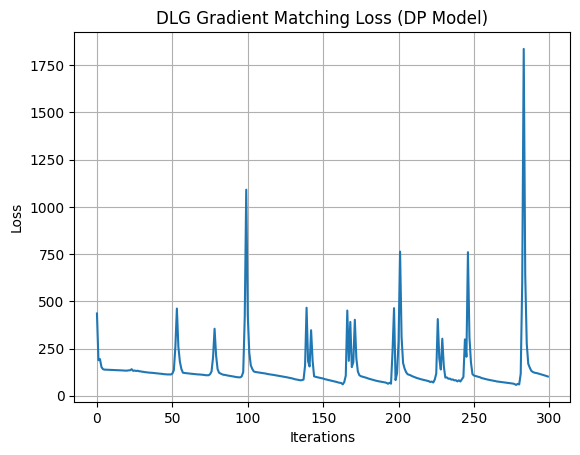

Original sample: tensor([1., 1., 0., 0., 1.])
Reconstructed sample: tensor([-0.3849, -0.2844, -1.2129, -0.1093,  0.7076])


In [20]:
import matplotlib.pyplot as plt

plt.plot(history)
plt.title("DLG Gradient Matching Loss (DP Model)")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Original sample:", X_sample[0][:5].detach().cpu())
print("Reconstructed sample:", dummy_data[0][:5].detach().cpu())


In [21]:
#to show how far the reconstruction was
import torch.nn.functional as F

mse = F.mse_loss(dummy_data.detach(), X_sample.detach())
print("MSE between original and reconstructed:", mse.item())


MSE between original and reconstructed: 22.47847557067871


In [22]:
# Define model architecture again (same as training) for gradient leakage attack without DP
class MLP(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        return self.model(x)

# Initialize model for DLG simulation
model_attack = MLP(input_dim, num_classes).to(device)

# ✅ Extract raw model weights from Opacus wrapper
raw_model = model._module
model_attack.load_state_dict(raw_model.state_dict())

model_attack.eval()


MLP(
  (model): Sequential(
    (0): Linear(in_features=38, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=5, bias=True)
  )
)

In [23]:
# getting the gradients ready for DLG attack without DP
import torch.nn as nn

loss_fn = nn.CrossEntropyLoss()



# Get one training batch
X_sample, y_sample = next(iter(train_loader))
X_sample = X_sample[:1].to(device)
y_sample = y_sample[:1].to(device)
# Compute gradients
model_attack.zero_grad()
preds = model_attack(X_sample)
loss = loss_fn(preds, y_sample)
loss.backward()

# Save gradients
grads = []
for param in model_attack.parameters():
    if param.grad is not None:
        grads.append(param.grad.detach().clone())

print("✅ Gradients extracted. Ready for DLG attack.")


✅ Gradients extracted. Ready for DLG attack.


In [24]:
#stimulating DLG attack without DP and HE
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

dummy_data = torch.randn_like(X_sample, requires_grad=True)
dummy_label = y_sample.clone()

optimizer_recon = LBFGS([dummy_data])
loss_fn = nn.CrossEntropyLoss()
history = []

for iteration in tqdm(range(300)):
    def closure():
        optimizer_recon.zero_grad()

        pred = model_attack(dummy_data)
        loss_dummy = loss_fn(pred, dummy_label)

        dummy_grads = torch.autograd.grad(loss_dummy, model_attack.parameters(), create_graph=True)

        # Compute gradient difference loss
        grad_diff = 0.0
        for i, g in enumerate(dummy_grads):
            grad_diff += ((g - grads[i])**2).sum()

        grad_diff.backward()
        history.append(grad_diff.item())

        return grad_diff

    optimizer_recon.step(closure)



  0%|          | 0/300 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/optim/lbfgs.py:457: UserWarning: Converting a tensor with requires_grad=True to a scalar may lead to unexpected behavior.
Consider using tensor.detach() first. (Triggered internally at /pytorch/torch/csrc/autograd/generated/python_variable_methods.cpp:835.)
  loss = float(closure())
100%|██████████| 300/300 [00:02<00:00, 139.45it/s]


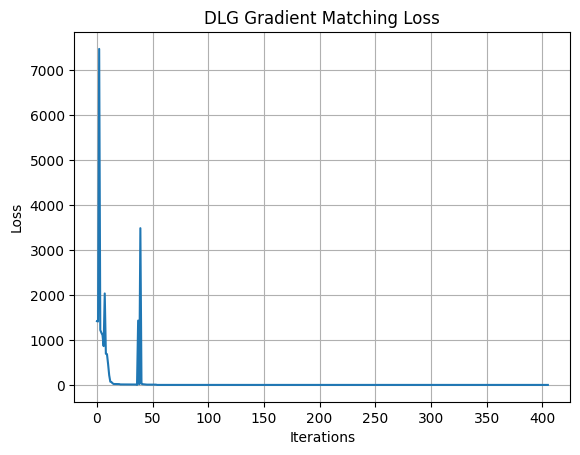

Original input sample: tensor([3., 2., 0., 1., 1.])
Reconstructed input: tensor([ 3.0000e+00,  2.0000e+00, -1.9552e-06,  1.0000e+00,  1.0000e+00])


In [25]:
#Result
plt.plot(history)
plt.title("DLG Gradient Matching Loss")
plt.xlabel("Iterations")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

print("Original input sample:", X_sample[0][:5].detach().cpu())
print("Reconstructed input:", dummy_data[0][:5].detach().cpu())


In [26]:
model.eval()
with torch.no_grad():
    y_train_pred = model(X_train_tensor).argmax(dim=1)
    y_val_pred = model(X_val_tensor).argmax(dim=1)

train_acc = accuracy_score(y_train_tensor, y_train_pred)
val_acc = accuracy_score(y_val_tensor, y_val_pred)

print(f"\n✅ Training Accuracy: {train_acc:.4f}")
print(f"✅ Validation Accuracy: {val_acc:.4f}\n")

print("📊 Classification Report (Validation):")
print(classification_report(y_val_tensor, y_val_pred, target_names=[str(c) for c in le_target.classes_]))


epsilon = privacy_engine.accountant.get_epsilon(delta=1e-5)
print(f"\n🔐 Differential Privacy Epsilon: {epsilon:.2f} (δ=1e-5)")




✅ Training Accuracy: 0.7330
✅ Validation Accuracy: 0.7456

📊 Classification Report (Validation):
                  precision    recall  f1-score   support

Extremely Severe       0.92      0.84      0.88       880
            Mild       0.45      0.82      0.58       243
        Moderate       0.77      0.48      0.59       472
          Normal       0.98      0.78      0.87       568
          Severe       0.54      0.76      0.63       412

        accuracy                           0.75      2575
       macro avg       0.73      0.74      0.71      2575
    weighted avg       0.80      0.75      0.76      2575


🔐 Differential Privacy Epsilon: 1.01 (δ=1e-5)


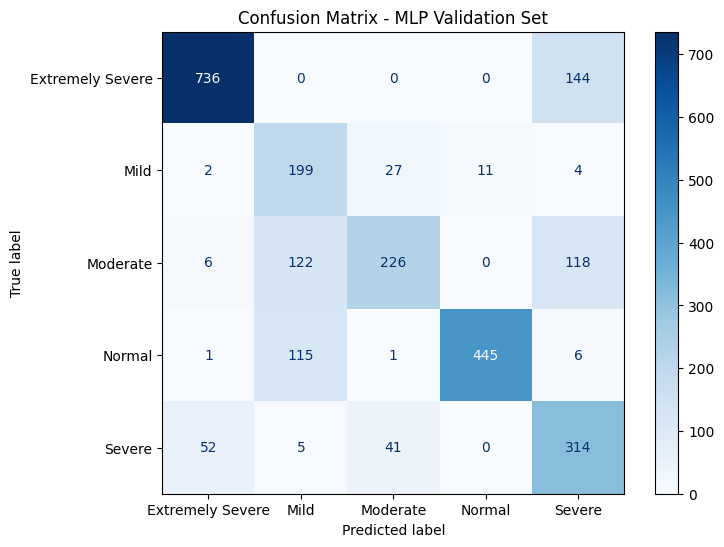

In [27]:
import torch
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# STEP 1: Predict using the trained MLP model
model.eval()
with torch.no_grad():
    y_val_logits = model(X_val_tensor)
    y_val_pred = torch.argmax(y_val_logits, dim=1).cpu().numpy()

# STEP 2: Optional - decode integer labels to original class names if you used LabelEncoder
class_labels = [str(cls) for cls in le_target.classes_]  # Converts int64 to string labels

# STEP 3: Generate the confusion matrix
cm = confusion_matrix(y_val, y_val_pred)

# STEP 4: Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, cmap='Blues', values_format='d')
plt.title("Confusion Matrix - MLP Validation Set")
plt.show()


In [ ]:
# !apt-get update
# !apt-get install -y cmake g++ wget git

# # Install latest PyTorch (CPU-only is fine for TenSEAL)
# !pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cpu



In [ ]:
# !rm -rf TenSEAL
# !git clone https://github.com/OpenMined/TenSEAL.git
# %cd TenSEAL

# # Install pybind11 (needed for C++ binding)
# !pip install pybind11


In [ ]:

# !python setup.py install


In [28]:
# # Run in terminal or ! in Jupyter
!pip install tenseal

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 22.2 MB/s eta 0:00:00


In [29]:
import tenseal as ts
import numpy as np
import torch

In [30]:
# Simulate a dummy gradient from a layer (e.g., 5 parameters)
local_gradient = torch.tensor([0.25, -0.3, 0.1, 0.55, -0.12], dtype=torch.float32)

print("📈 Original Gradient (Local Model):")
print(local_gradient.numpy())


📈 Original Gradient (Local Model):
[ 0.25 -0.3   0.1   0.55 -0.12]


In [ ]:
# # CKKS encryption context setup
# context = ts.context(
#     ts.SCHEME_TYPE.CKKS,
#     poly_modulus_degree=8192,
#     coeff_mod_bit_sizes=[60, 40, 40, 60]
# )
# context.generate_galois_keys()
# context.global_scale = 2**40

# # Save public & secret key (just for simulation; normally private key stays secure)
# public_context = context.copy()  # This is what would be shared with the server
# public_context.make_context_public()  # Only allows encryption



In [31]:
def encrypt_gradients_from_model(model, X_batch, y_batch, loss_fn, context):
    model.train()
    model.zero_grad()

    outputs = model(X_batch)
    loss = loss_fn(outputs, y_batch)
    loss.backward()

    encrypted_grads = {}

    for name, param in model.named_parameters():
        if param.requires_grad and param.grad is not None:
            grad = param.grad.view(-1).detach().cpu().numpy()
            enc_grad = ts.ckks_vector(context, grad.tolist())
            encrypted_grads[name] = enc_grad

            print(f"\n Layer: {name}")
            print(f"Original Gradient Sample: {grad[:5]}")
            print(f"Encrypted Gradient Sample (decrypted view): {enc_grad.decrypt()[:5]}")

    return encrypted_grads

In [ ]:
# import torch.nn as nn

# loss_fn = nn.CrossEntropyLoss()

# # Get one batch from your train loader
# X_sample, y_sample = next(iter(train_loader))
# X_sample, y_sample = X_sample.to(device), y_sample.to(device)

# # Run encryption on gradients
# encrypted_grads = encrypt_gradients_from_model(model, X_sample, y_sample, loss_fn, context)


In [32]:
#encrypt the gradints and get get one sampple for DLG attack
import tenseal as ts

# Setup HE context
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2**40
public_context = context.copy()
public_context.make_context_public()

# Get one batch
X_sample, y_sample = next(iter(train_loader))
X_sample = X_sample[:1].to(device)
y_sample = y_sample[:1].to(device)

# Encrypt gradients
encrypted_grads = encrypt_gradients_from_model(model_attack, X_sample, y_sample, loss_fn, context)


The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.

 Layer: model.0.weight
Original Gradient Sample: [0. 0. 0. 0. 0.]
Encrypted Gradient Sample (decrypted view): [1.7735353604025328e-10, -6.263102253820052e-11, -1.0040309235508157e-09, -1.088105011885723e-09, 5.107853476662462e-10]

 Layer: model.0.bias
Original Gradient Sample: [ 0.         -0.00016253 -0.00032509  0.         -0.00019354]
Encrypted Gradient Sample (decrypted view): [5.560822145501873e-10, -0.00016253368408568295, -0.00032509084678076334, -6.186736124998106e-10, -0.00019353552474023767]
The following operations are disabled in this setup: matmul, matmul_plain, enc_matmul_plain, conv2d_im2col.
If you need to use those operations, try increasing the poly_modulus parameter, to fit your input.

 Layer: model.2.weight
Original Gradient Sample: [-0.         -0.00093766 -0

In [33]:
# Simulate attacker trying to use encrypted_grads
for name, enc_grad in encrypted_grads.items():
    print(f"Encrypted gradient for {name}:")
    print(enc_grad.serialize()[:60], "...")  # Just to show it's ciphertext


Encrypted gradient for model.0.weight:
b'\n\x04\x80 \x80\x06\x12\xe2\xb4\x14^\xa1\x10\x04\x01\x02\x00\x00b\x1a\x05\x00\x00\x00\x00\x00(\xb5/\xfd\xa0a\x00\x06\x00\xb4Z\x0e\x8e\xfd_\xd1r-\x10\xa0\xbcf\\bn\xa6\xab\xe8A&p0i)' ...
Encrypted gradient for model.0.bias:
b'\n\x02\x80\x01\x12\x95\xb2\x14^\xa1\x10\x04\x01\x02\x00\x00\x15\x19\x05\x00\x00\x00\x00\x00(\xb5/\xfd\xa0a\x00\x06\x00\x84[\x0e\x8e\xfd\xdf\xd7r-\x10\xa0\xbcf\xf6\xf3\xb8>\xf0S\xc3\xd4M\xc5\xeb\xdc(\x98' ...
Encrypted gradient for model.2.weight:
b'\n\x04\x80 \x80 \x12\xd1\xb2\x14^\xa1\x10\x04\x01\x02\x00\x00Q\x19\x05\x00\x00\x00\x00\x00(\xb5/\xfd\xa0a\x00\x06\x00\x0c\\\x0e\x8e\xfd\x1f\xdcr.\x10\xa0\xbcf\x07\x92\x97[\xb1\xd9p\x04\xbf\x16Mb' ...
Encrypted gradient for model.2.bias:
b'\n\x01@\x12\x8f\xac\x14^\xa1\x10\x04\x01\x02\x00\x00\x0f\x16\x05\x00\x00\x00\x00\x00(\xb5/\xfd\xa0a\x00\x06\x00\xfc[\x0e\x8e\xfd\x9f\xdbr.\x10\xa0\xbcf\x8e$\xe0i\xbc\xe1\xd1\x06\x8c\x0c\x19\xb8\x1fX\x11' ...
Encrypted gradient for model.4.weight:
